In [38]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply

from qtrader.core.security import Security, Stock
from qtrader.core.constants import Exchange
from qtrader.core.data import _get_data
from qtrader.plugins.analysis.metrics import sharpe_ratio
from qtalib.indicators import CYC, SAR
from qtrader_config import *

In [39]:
def load_data(
        security: Security,
        data_start: datetime,
        start: datetime,
        end: datetime,
        lookback_period: int = None
) -> pd.DataFrame:
    """Load OHLCV"""
    data = _get_data(
        security=security,
        start=data_start,
        end=end,
        dfield="kline",
        dtype=['time_key', 'open', 'high', 'low', 'close', 'volume']
    ).set_index("time_key")
    data = data.ffill().bfill()
    if data[data.index <= start].shape[0] < lookback_period:
        raise ValueError("There is not enough lookback data, change data_start")
    ret_data = pd.concat(
        [data[data.index <= start].iloc[-lookback_period:],
         data[data.index > start]]
    )
    return ret_data

In [40]:
security = Stock(
    code="US.SPY",
    lot_size=1,
    security_name="US.SPY",
    exchange=Exchange.SMART
)

# data_start = datetime(2020, 11, 15, 0, 0, 0)
# start = datetime(2021, 2, 1, 0, 0, 0)
# end = datetime(2022, 12, 1, 23, 59, 59)
# lookback_window = 194

data_start = datetime(2016, 1, 1, 0, 0, 0)
start = datetime(2018, 1, 1, 0, 0, 0)
end = datetime(2022, 12, 1, 23, 59, 59)
lookback_window = 350

# Load data
data = load_data(security, data_start, start, end, lookback_window)

2016-01-04 is not a valid date format! Return default datetime instead.
2017-01-03 is not a valid date format! Return default datetime instead.
2018-01-02 is not a valid date format! Return default datetime instead.
2019-01-02 is not a valid date format! Return default datetime instead.
2020-01-02 is not a valid date format! Return default datetime instead.
2021-01-04 is not a valid date format! Return default datetime instead.


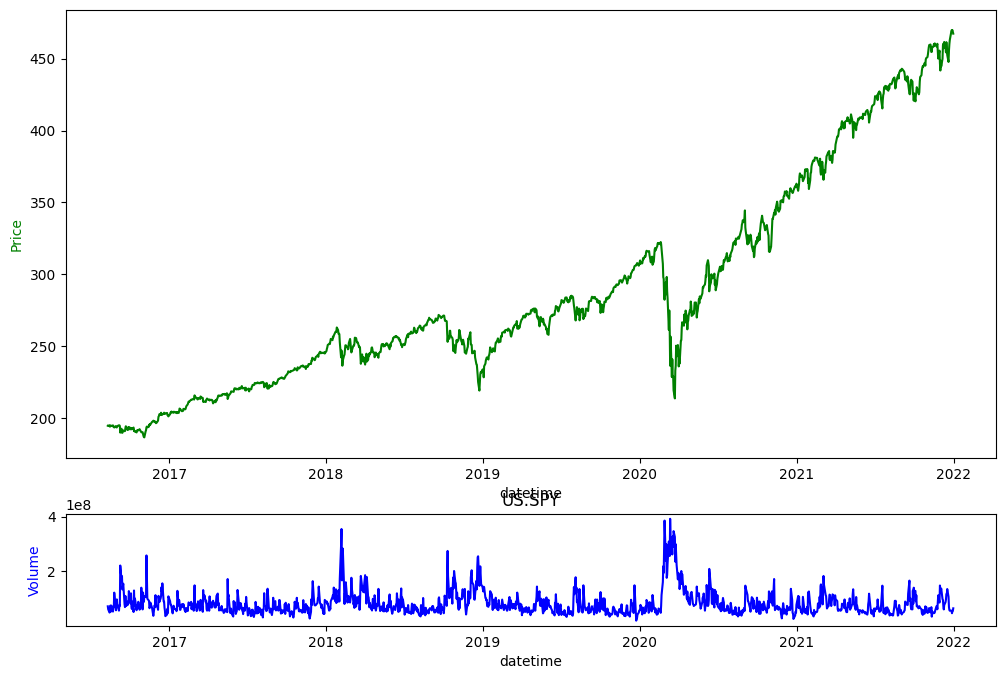

In [41]:
fig, (ax1, ax2) = plt.subplots(
    2, figsize=(12,8), gridspec_kw={'height_ratios': [4, 1]})
ax1.plot(data.index, data.close, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='g')
ax2.plot(data.index, data.volume, 'b-')
ax2.set_xlabel('datetime')
ax2.set_ylabel('Volume', color='b')
plt.title(security.code)
plt.show()

In [93]:
cyc = {
    "close": 0,
    "volume": 0
}
PCY = []
VOC = []
SAR_lst = []
for idx in range(lookback_window, data.shape[0]):
    data_lb = data.iloc[idx-lookback_window+1:idx+1]
    highs = data_lb["high"].to_numpy(dtype=float)
    lows = data_lb["low"].to_numpy(dtype=float)
    closes = data_lb["close"].to_numpy(dtype=float)
    volumes = data_lb["volume"].to_numpy(dtype=float)
    cyc["close"] = CYC(
        data=closes,
        cyc=cyc["close"],
        short_ma_length=14,
        long_ma_length=30,
        alpha=0.2896488053386398,
        lookback_window=10,
    )
    PCY.append(cyc["close"])
    cyc["volume"] = CYC(
        data=volumes,
        cyc=cyc["volume"],
        short_ma_length=14,
        long_ma_length=35,
        alpha=0.322,
        lookback_window=40,
    )
    VOC.append(cyc["volume"])
    sar = SAR(
        highs,
        lows
    )[-1]
    SAR_lst.append(sar)

In [94]:
data_bt = data.iloc[lookback_window:].copy()
data_bt["VOC"] = VOC
data_bt["PCY"] = PCY
data_bt["SAR"] = SAR_lst

## Correlation

Check Pearson correlation between PCY and prices

In [95]:
def corr(x, y):
    return np.corrcoef(x, y)[0][1]

In [96]:
n = len(data_bt) // 3
rolling_corr_pcy = rolling_apply(
    corr,
    n,
    data_bt.PCY.diff().apply(lambda x: np.sign(x)).dropna().values,
    data_bt.close.diff().apply(lambda x: np.sign(x)).dropna().values
)
rolling_corr_pcy = rolling_corr_pcy[~np.isnan(rolling_corr_pcy)]

Check correlation between VOC and volumes

In [97]:
n = len(data_bt) // 3
rolling_corr_voc = rolling_apply(
    corr,
    n,
    data_bt.VOC.diff().apply(lambda x: np.sign(x)).dropna().values,
    data_bt.volume.diff().apply(lambda x: np.sign(x)).dropna().values
)
rolling_corr_voc = rolling_corr_voc[~np.isnan(rolling_corr_voc)]


In [98]:
print(
    f"VOC range: [{data_bt['VOC'].min()}, {data_bt['VOC'].max()}]\n"
    f"Correlation(VOC, price_trends): "
    f"[{rolling_corr_voc.min()}, {rolling_corr_voc.max()}],"
    f"mean={rolling_corr_voc.mean()}\n"
    f"PCY range: [{data_bt['PCY'].min()}, {data_bt['PCY'].max()}]\n"
    f"Correlation(PCY, price): "
    f"[{rolling_corr_pcy.min()}, {rolling_corr_pcy.max()}],"
    f"mean={rolling_corr_pcy.mean()}\n"
)


VOC range: [0.18307450119009866, 99.98108230130771]
Correlation(VOC, price_trends): [-0.009623058791130587, 0.07829898781736017],mean=0.046696769217154724
PCY range: [0.0, 99.97149280548689]
Correlation(PCY, price): [-0.018676790002067848, 0.12185425309968347],mean=0.07466210384249485



buy & sell signals

In [99]:
pcy_mean = data_bt.PCY.mean()
pcy_std = data_bt.PCY.std()
voc_mean = data_bt.VOC.mean()
voc_std = data_bt.VOC.std()
print(
    f"PCY mean: {pcy_mean}; PCY std: {pcy_std}\n"
    f"VOC mean: {voc_mean}; VOC std: {voc_std}"
)

PCY mean: 45.81328969791676; PCY std: 39.27533065202048
VOC mean: 50.188992170150485; VOC std: 32.26500849587088


In [190]:
# data_bt["entry_long1"] = rolling_apply(
#     lambda VOC: int(VOC[0]>VOC[1] and VOC[2]>VOC[1]),
#     3,
#     data_bt.VOC.values
# )
# data_bt["entry_long2"] = rolling_apply(
#     lambda VOC, PCY: int(VOC[0]>VOC[1] and VOC[2]>VOC[1] and PCY[2]>PCY[1]),
#     3,
#     data_bt.VOC.values, data_bt.PCY.values
# )

# VOC bottom, PCY bottom
pcy_entry_long_threshold = 10
data_bt["entry_long"] = rolling_apply(
    lambda VOC, PCY, SAR_, close_: int(
        PCY[0] > PCY[1]
        and PCY[1] < PCY[2]
        and PCY[1] < pcy_entry_long_threshold
    ),
    3,
    data_bt.VOC.values,
    data_bt.PCY.values,
    data_bt.SAR.values,
    data_bt.close.values
)
# VOC bottom, PCY top
pcy_entry_short_threshold = 90
voc_entry_short_threshold = 20
data_bt["entry_short"] = rolling_apply(
    lambda VOC, PCY, SAR_, close_: int(
        PCY[0] < PCY[1]
        and PCY[1] > PCY[2]
        and PCY[1] > pcy_entry_short_threshold
        and VOC[1] < voc_entry_short_threshold
    ),
    3,
    data_bt.VOC.values,
    data_bt.PCY.values,
    data_bt.SAR.values,
    data_bt.close.values
)

voc_exit_long_threshold = 50
pcy_exit_long_threshold = 50
data_bt["exit_long"] = rolling_apply(
    lambda VOC, PCY: int(
        PCY[1] < PCY[0]
        and VOC[1] > VOC[0]
        and PCY[1] < VOC[1]
        and PCY[0] > VOC[0]
        and PCY[0] < pcy_exit_long_threshold
        and VOC[1] < voc_exit_long_threshold
    ),
    2,
    data_bt.VOC.values,
    data_bt.PCY.values,
)

voc_exit_short_threshold = 50
pcy_exit_short_threshold = 50
data_bt["exit_short"] = rolling_apply(
    lambda VOC, PCY: int(
        PCY[1] > PCY[0]
        and VOC[1] < VOC[0]
        and PCY[1] > VOC[1]
        and PCY[0] < VOC[0]
        and PCY[0] > pcy_exit_short_threshold
        and VOC[1] > voc_exit_short_threshold
    ),
    3,
    data_bt.VOC.values,
    data_bt.PCY.values
)

In [191]:
data_bt_plot = data_bt[
    (data_bt.index > datetime(2020, 1, 1))
    & (data_bt.index < datetime(2020, 12, 31))
]
data_bt_plot_entry_long = data_bt_plot[data_bt_plot.entry_long==1]
data_bt_plot_exit_long = data_bt_plot[data_bt_plot.exit_long==1]
data_bt_plot_entry_short = data_bt_plot[data_bt_plot.entry_short==1]
data_bt_plot_exit_short = data_bt_plot[data_bt_plot.exit_short==1]

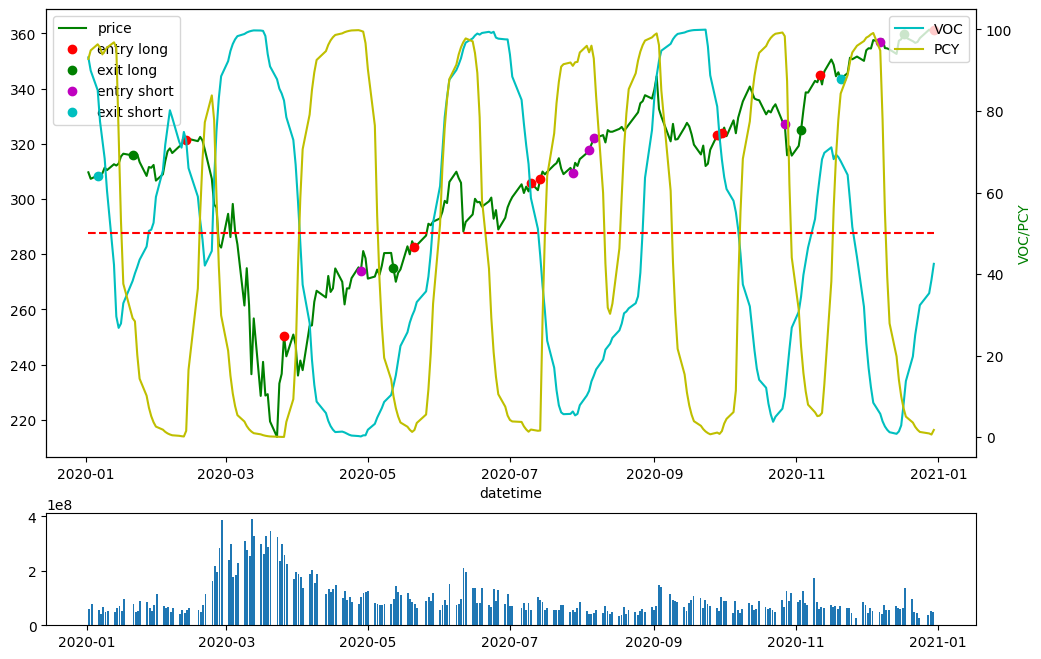

In [192]:
fig, (ax1, ax3) = plt.subplots(
    2, figsize=(12,8), gridspec_kw={'height_ratios': [4, 1]})
ax2 = ax1.twinx()
ax1.plot(data_bt_plot.index, data_bt_plot.close, 'g-', label='price')
ax1.plot(data_bt_plot_entry_long.index,
         data_bt_plot_entry_long.close, 'ro', label='entry long')
ax1.plot(data_bt_plot_exit_long.index,
         data_bt_plot_exit_long.close, 'go', label='exit long')
ax1.plot(data_bt_plot_entry_short.index,
         data_bt_plot_entry_short.close, 'mo', label='entry short')
ax1.plot(data_bt_plot_exit_short.index,
         data_bt_plot_exit_short.close, 'co', label='exit short')
ax2.plot(data_bt_plot.index, data_bt_plot.VOC, 'c-', label='VOC')
ax2.plot(data_bt_plot.index, data_bt_plot.PCY, 'y-', label='PCY')
ax2.plot(data_bt_plot.index, [50.] * len(data_bt_plot.PCY), 'r--')
ax1.legend(loc=0)
ax2.legend(loc=1)
ax1.set_xlabel('datetime')
ax2.set_ylabel('Price', color='b')
ax2.set_ylabel('VOC/PCY', color='g')
ax3.bar(data_bt_plot.index, data_bt_plot.volume, label='volume')

plt.show()


Long only

In [193]:
entry_long_signal = "entry_long"
exit_long_signal = "exit_long"
pos = 0
open_time_lst = []
cost_lst = []
trades = []
stop_trades = []
pnls = []
for i in range(len(data_bt)):
    row = data_bt.iloc[i]
    dt = data_bt.index[i]
    pnl = 0
    # update pnl
    for idx, cost in enumerate(cost_lst):
        prev_row = data_bt.iloc[i-1]
        pnl += (row.close - prev_row.close) / cost
    if row[entry_long_signal] == 1:
        if pos == 0:
            pos += 1
            cost_lst.append(row.close)
            open_time_lst.append(dt)
        elif pos > 0:
            lowest_cost = min(cost_lst)
            if True: # row.close < lowest_cost:
                pos += 1
                cost_lst.append(row.close)
                open_time_lst.append(dt)
        else:
            raise ValueError("Long only should not have short position!")
    elif pos > 0:
        # SAR stop loss
        if row[exit_long_signal]: # or row.SAR > row.close:
            print(dt, len(cost_lst), row.SAR > row.close, row[exit_long_signal])
            for idx, cost in enumerate(cost_lst):
                pos -= 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            cost_lst = []
            open_time_lst = []
    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

2018-03-29 00:00:00 1 True 1.0
2018-05-11 00:00:00 1 False 1.0
2018-08-10 00:00:00 2 False 1.0
2018-12-10 00:00:00 4 True 1.0
2019-02-14 00:00:00 1 False 1.0
2019-05-02 00:00:00 2 True 1.0
2019-07-23 00:00:00 1 True 1.0
2019-10-02 00:00:00 1 True 1.0
2020-01-21 00:00:00 3 False 1.0
2020-05-12 00:00:00 2 False 1.0
2020-11-03 00:00:00 5 True 1.0
2020-12-17 00:00:00 1 False 1.0
2021-05-05 00:00:00 5 True 1.0
2021-06-29 00:00:00 1 False 1.0
2021-11-19 00:00:00 2 False 1.0


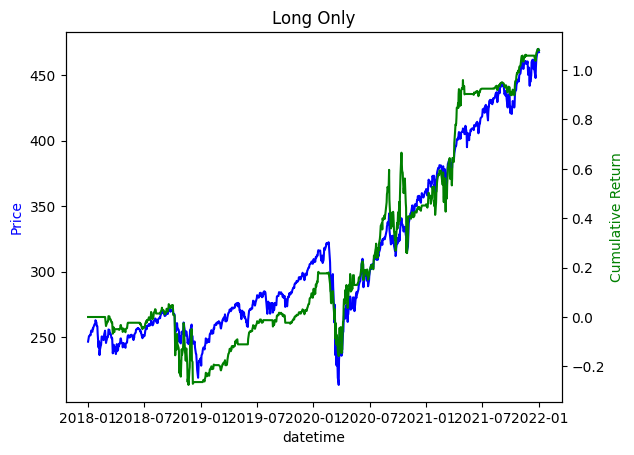

In [194]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.title("Long Only")
plt.show()

In [195]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]
df_daily = data_bt.resample('D').agg(
    {"equity": "last"}).dropna()
sr = sharpe_ratio(
    returns=df_daily["equity"].diff().dropna(),
    days=252
)
total_return = df_daily.iloc[-1]["equity"]
annual_return = total_return * 252 / df_daily.shape[0]

In [196]:
print(
    "________ <Long Only> ________\n"
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
    f"Sharpe ratio: {sr}\n"
    f"Total return: {total_return}\n"
    f"annual_return: {annual_return}\n"
)

________ <Long Only> ________
number of trades: 32
number of stop trades: 32
number of win trades: 25
number of lose trades: 7
win trade ratio: 0.78125
maximum win trade: 0.14915129263437307
maximum lose trade: -0.14449308443190198
Sharpe ratio: 0.7368684211880375
Total return: 1.080232062625125
annual_return: 0.27005801565628124



Long Short

In [197]:
entry_long_signal = "entry_long"
entry_short_signal = "entry_short"
exit_long_signal = "exit_long"
exit_short_signal = "exit_short"
pos = 0
open_time_lst = []
cost_lst = []
trades = []
stop_trades = []
pnls = []
for i in range(len(data_bt)):
    row = data_bt.iloc[i]
    dt = data_bt.index[i]
    pnl = 0
    # update pnl
    for idx, cost in enumerate(cost_lst):
        prev_row = data_bt.iloc[i-1]
        if pos > 0:
            pnl += (row.close - prev_row.close) / cost
        else:
            pnl += -(row.close - prev_row.close) / cost

    if row[entry_long_signal] == 1:
        # close short
        if pos < 0:
            for idx, cost in enumerate(cost_lst):
                pos += 1
                close_time = dt
                open_time = open_time_lst[idx]
                prev_row = data_bt.iloc[i-1]
                cum_pnl = -(row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            assert pos == 0, "position incorrect"
            cost_lst = []
            open_time_lst = []
        # open long
        elif pos == 0:
            pos += 1
            cost_lst.append(row.close)
            open_time_lst.append(dt)
        elif pos > 0:
            lowest_cost = min(cost_lst)
            if True: # row.close < lowest_cost:
                pos += 1
                cost_lst.append(row.close)
                open_time_lst.append(dt)
    elif row[entry_short_signal] == 1:
        # close long
        if pos > 0:
            for idx, cost in enumerate(cost_lst):
                pos -= 1
                close_time = dt
                open_time = open_time_lst[idx]
                prev_row = data_bt.iloc[i-1]
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            assert pos == 0, "position incorrect"
            cost_lst = []
            open_time_lst = []
        # open short
        elif pos == 0:
            pos -= 1
            cost_lst.append(row.close)
            open_time_lst.append(dt)
        elif pos < 0:
            highest_cost = max(cost_lst)
            if True: # row.close > highest_cost:
                pos -= 1
                cost_lst.append(row.close)
                open_time_lst.append(dt)
    elif pos > 0:
        # SAR stop loss
        if row[exit_long_signal]:  # or row.SAR > row.close:
            for idx, cost in enumerate(cost_lst):
                pos -= 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            cost_lst = []
            open_time_lst = []
    elif pos < 0:
        # SAR stop loss
        if row[exit_short_signal]:  # or row.SAR < row.close:
            for idx, cost in enumerate(cost_lst):
                pos += 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                cum_pnl = -(row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            cost_lst = []
            open_time_lst = []
    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

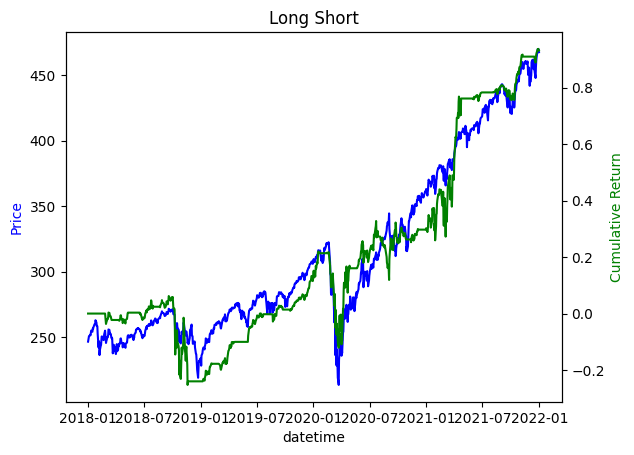

In [198]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.title("Long Short")
plt.show()

In [199]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]
df_daily = data_bt.resample('D').agg(
    {"equity": "last"}).dropna()
sr = sharpe_ratio(
    returns=df_daily["equity"].diff().dropna(),
    days=252
)
total_return = df_daily.iloc[-1]["equity"]
annual_return = total_return * 252 / df_daily.shape[0]

In [200]:
print(
    "________ <Long Short> ________\n"
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
    f"Sharpe ratio: {sr}\n"
    f"Total return: {total_return}\n"
    f"annual_return: {annual_return}\n"
)



________ <Long Short> ________
number of trades: 33
number of stop trades: 6
number of win trades: 25
number of lose trades: 8
win trade ratio: 0.7575757575757576
maximum win trade: 0.1259655040110137
maximum lose trade: -0.14729831867557583
Sharpe ratio: 0.8112588399936266
Total return: 0.9322183657121434
annual_return: 0.23305459142803586

